<a href="https://colab.research.google.com/github/S4b3/PITC-21-22/blob/main/Copia_di_consumptions_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sync Code

Clone the GitHub Repo

In [ ]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

Cloning into 'training_camp_21_22'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 6), reused 25 (delta 5), pack-reused 0
Unpacking objects: 100% (29/29), done.


Move to the Python Project root folder and install requirements

In [ ]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 9.8 MB 42.4 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 554 kB 55.2 MB/s 
     |████████████████████████████████| 13.1 MB 56.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.6 MB/s 
     |████████████████████████████████| 15.8 MB 62.3 MB/s 
     |████████████████████████████████| 438 kB 44.4 MB/s 
     |████████████████████████████████| 1.6 MB 52.4 MB/s 
     |████████████████████████████████| 5.8 MB 43.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-prediction

In [ ]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

In [ ]:
#!gdown 1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN -O  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Download the input file (training and test)

In [ ]:
!mkdir -p data/task_1
!mkdir -p data/task_2

In [ ]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [ ]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

  0% 0.00/23.1M [00:00<?, ?B/s]
100% 23.1M/23.1M [00:00<00:00, 259MB/s]
Archive:  pitc-2122-clustering.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd ../task_2

/content/training_camp_21_22/data/task_2


In [ ]:
!kaggle competitions download -c pitc-2122-prediction
!unzip pitc-2122-prediction.zip

 63% 50.0M/79.3M [00:00<00:00, 214MB/s]
100% 79.3M/79.3M [00:00<00:00, 251MB/s]
Archive:  pitc-2122-prediction.zip
  inflating: solution_sample.csv     
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


# Import packages

Move back to the Python project folder

In [ ]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [ ]:
import datetime
import random
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import json
import tensorflow as tf
import itertools

import training_camp_21_22.config
import training_camp_21_22.models

import training_camp_21_22.models.baseline
import training_camp_21_22.data.window_generator

# Preprocess Data

Parse the data (see the previous task!)

In [ ]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path, train = True):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    csv_df = pd.DataFrame(columns=[
      "user_month_year",
      "legalNature",
      "citizenshipNoUSA",
      "billing_range.from_date",
      "billing_range.to_date",
      "fasciaF0ConsumoFatturato",
      "fasciaF1ConsumoFatturato",
      "fasciaF2ConsumoFatturato",
      "fasciaF3ConsumoFatturato",
      "fasciaF4ConsumoFatturato",
      "fasciaF5ConsumoFatturato",
      "fasciaF6ConsumoFatturato",
      "res_address_code",
      "res_address_value",
      "dom_address_code",
      "dom_address_value"
    ])


    d = {}
    labels = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[1]) :
            # read consumer id
            id = row[0]

            # billing_range
            billing_range = bill['customData']['billing_range']
            energy = bill['customData']['energy']
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            

            d[i] = {
              'user_month_year' : id,
              'legalNature' : bill['bamData']['items']['bamItem']['legalNature'],
              'citizenshipNoUSA' : bill['bamData']['items']['bamItem']['personInfo']['citizenshipNoUSA'],
              'billing_range.from_date' : billing_range['from_date'],
              'billing_range.to_date' : billing_range['to_date'],
              'f1' : energy['fasciaF1ConsumoFatturato'],
              'f2' : energy['fasciaF2ConsumoFatturato'],
              'f3' : energy['fasciaF3ConsumoFatturato'],
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value
            }
            i = i+1

          if(train):
            labels[j] = {'userID' : row[0] , 'next_f1': float(row[2]),' next_f2': float(row[3]), 'next_f3': float(row[3]) }
            j += 1


    if(train):
      return pd.DataFrame.from_dict(d, "index"), pd.DataFrame.from_dict(labels, 'index')
    return  pd.DataFrame.from_dict(d, "index")


features_df = convert_json_2_pd(json_input_path="data/task_2/test.csv", train = False)

110000it [00:14, 7563.21it/s]


In [ ]:
features_df

,user_month_year,legalNature,citizenshipNoUSA,billing_range.from_date,billing_range.to_date,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value
0,90000_07_2022,PF,False,2022-07-01,2022-07-31,0.0,34.0,33.0,B076,Boscoreale,G267,Palazzolo Acreide
1,90000_08_2022,PF,False,2022-08-01,2022-08-31,0.0,25.0,35.0,B076,Boscoreale,G267,Palazzolo Acreide
2,90000_09_2022,PF,False,2022-09-01,2022-09-30,2.0,20.0,33.0,B076,Boscoreale,G267,Palazzolo Acreide
3,90000_10_2022,PF,False,2022-10-01,2022-10-31,4.0,12.0,40.0,B076,Boscoreale,G267,Palazzolo Acreide
4,90000_11_2022,PF,False,2022-11-01,2022-11-30,3.0,3.0,38.0,B076,Boscoreale,G267,Palazzolo Acreide
...,...,...,...,...,...,...,...,...,...,...,...,...
109995,99999_01_2023,PF,False,2023-01-01,2023-01-31,46.0,49.0,20.0,E413,Lajatico,C745,Città di Castello
109996,99999_02_2023,PF,False,2023-02-01,2023-02-28,50.0,51.0,28.0,E413,Lajatico,C745,Città di Castello
109997,99999_03_2023,PF,False,2023-03-01,2023-03-31,49.0,46.0,37.0,E413,Lajatico,C745,Città di Castello
109998,99999_04_2023,PF,False,2023-04-01,2023-04-30,45.0,39.0,33.0,E413,Lajatico,C745,Città di Castello


Fill the missing data (for the data coming from the past history)

In [ ]:
def prepare_data(task="task_1"):
    task_path = os.path.join(training_camp_21_22.config.data_path, "task_1")
    if task == "task_2":
        task_path = os.path.join(training_camp_21_22.config.data_path, "task_2")

    train_features_ds_pd = pd.read_csv(
        os.path.join(task_path, "training_features.csv"),
        sep=";", encoding="latin1")
    # train_labels_ds_pd = pd.read_csv(
    #     os.path.join(task_path, "training_labels.csv"),
    #     sep=";", encoding="latin1")
    
    validation_features_ds_pd = pd.read_csv(
        os.path.join(task_path, "validation_features.csv"),
        sep=";", encoding="latin1")
    # validation_labels_ds_pd = pd.read_csv(
    #     os.path.join(task_path, "validation_labels.csv"),
    #     sep=";", encoding="latin1")

    test_features_ds_pd = pd.read_csv(
        os.path.join(task_path, "test_features.csv"),
        sep=";", encoding="latin1")
    # test_labels_ds_pd = pd.read_csv(
    #     os.path.join(task_path, "test_labels.csv"), sep=";",
    #     encoding="latin1")

    return train_features_ds_pd, validation_features_ds_pd, test_features_ds_pd


def impute_data(df):
    train_range = pd.date_range(
        start=datetime.datetime(year=2021, month=7, day=1),
        end=datetime.datetime(year=2022, month=6, day=1), freq="MS")

    df = df.drop(["city_density", "gender"], axis=1)

    imputed = pd.DataFrame()
    for user in list(set(df["user"])):
        # print("Elaborating user", user)
        cond = (df["user"] == user)
        if sum(np.array(cond)) > 3:
            tmp_df = df[cond].copy()

            tmp_df["date"] = tmp_df.apply(
                lambda row: datetime.datetime(
                    year=int(row.year), month=int(row.month), day=1), axis=1)
            tmp_df = tmp_df.set_index("date")
            # tmp_df = tmp_df.drop(["year", "month"], axis=1)
            tmp_df = tmp_df.drop(["year"], axis=1)

            tmp_df = tmp_df.reindex(train_range, fill_value=np.nan)
            tmp_df = tmp_df.interpolate(method="cubic").interpolate(
                fill_value="extrapolate", limit_direction="both")

            imputed = pd.concat([imputed, tmp_df])
            imputed = imputed.drop(["user"], axis=1)

    return imputed

def impute_data2(df,df_2,perc):
    # TASK 1
    train_range = pd.date_range(
        start=datetime.datetime(year=2021, month=7, day=1),
        end=datetime.datetime(year=2022, month=6, day=1), freq="MS")

    df = df.drop(["city_density"], axis=1)
    grouped = df.groupby('user')
    imputed = grouped.filter(lambda x: x['gender'].count() > 3)

    imputed = imputed.reset_index(drop = True)
    #imputed = imputed[imputed['user'] == 69963]
    imputed["date"] = imputed.apply(
        lambda row: datetime.datetime(
            year=int(row.year), month=int(row.month), day=1), axis=1)
    imputed = imputed.set_index("date")
    perc = int(len(df.user.unique())/perc)
    user_el = random.sample(list(df.user.unique()),perc)
    imputed = imputed[imputed.user.isin(user_el)]

    df_dt = pd.DataFrame(itertools.product(train_range,set(imputed.user)))
    df_dt.columns = ['date','user']
    
    tmp_df = imputed.merge(
        df_dt, how='outer', left_on=['date', 'user'], right_on=['date', 'user'])
    
    tmp_df = tmp_df.set_index(tmp_df.date)
    tmp_df = tmp_df.drop(["date"], axis=1)
    tmp_df = tmp_df.sort_index()
    tmp_df = tmp_df[["user", "f1", "f2", "f3"]]
    
    
    tmp_df = tmp_df.groupby("user").apply(
        lambda group: group.interpolate(method="cubic").interpolate(
            fill_value="extrapolate", limit_direction="both"))
    
    
    tmp_df.reset_index(drop = False,inplace = True)
    cond = ["user", "city_elevation", "is_resident", "upper_bound", "age"]
    imputed_app = imputed[cond].drop_duplicates()
    imputed1 = tmp_df.merge(
        imputed_app, how="left", left_on=["user"], right_on=["user"])
    imputed1["month"]= imputed1["date"].apply(lambda s: int(s.month))
    imputed1["year"]= imputed1["date"].apply(lambda s: int(s.year))
    imputed1 = imputed1.reindex(sorted(imputed1.columns), axis=1)
    
    # TASK 2 
    df_2["date"] = df_2.apply(
        lambda row: datetime.datetime(
            year=int(row.year), month=int(row.month), day=1), axis=1)
    df_2 = df_2.drop(["city_density", "gender"], axis=1)
  
    df_2 = df_2[df_2.user.isin(list(imputed1.user.unique()))]
    df_2 = df_2.reindex(sorted(df_2.columns), axis=1)
    df_tot = pd.concat([imputed1,df_2],axis = 0) 

    df_tot = df_tot.sort_values(by=["user", "date"])
    df_tot = df_tot.set_index("date")
    return df_tot 

In [ ]:
train_features_ds_pd_1, validation_features_ds_pd_1, test_features_ds_pd_1 = prepare_data("task_1")
train_features_ds_pd_2, validation_features_ds_pd_2, test_features_ds_pd_2 = prepare_data("task_2")

In [ ]:
train_df = impute_data2(train_features_ds_pd_1, train_features_ds_pd_2, 50)
val_df = impute_data2(validation_features_ds_pd_1, validation_features_ds_pd_2, 50)
test_df = impute_data2(test_features_ds_pd_1, test_features_ds_pd_2, 50)

In [ ]:
print(train_df)

            age  city_elevation         f1         f2         f3  is_resident  \
date                                                                            
2021-07-01   65           191.0  24.000000  74.000000  22.000000            1   
2021-08-01   65           191.0  24.000000  74.000000  22.000000            1   
2021-09-01   65           191.0  34.111413  73.835893  42.699787            1   
2021-10-01   65           191.0  35.154412  68.921249  57.448956            1   
2021-11-01   65           191.0  33.000000  62.000000  67.000000            1   
...         ...             ...        ...        ...        ...          ...   
2023-02-01   72            15.0  13.000000  25.000000  16.000000            0   
2023-03-01   72            15.0  15.000000  25.000000  15.000000            0   
2023-04-01   72            15.0  11.000000  26.000000   9.000000            0   
2023-05-01   72            15.0   8.000000  23.000000  11.000000            0   
2023-06-01   72            1

# Model

Define a function for train and evaluate 

In [ ]:
def train_evaluate_model(
        model, train_window, plot_window,
        val_performance, test_performance):

    history = model.compile_and_fit(train_window)

    val_performance[model.name] = model.evaluate(
        train_window.val)
    test_performance[model.name] = model.evaluate(
        train_window.test, verbose=False)

    print(f"Final plot {model.name}")
    plot_window.plot(model)

    return history


In [ ]:
train_2022_05 = train_df[(train_df.index <= '2022-05-01')]
val_2022_05 = val_df[(val_df.index <= '2022-05-01')]
test_2022_05 = test_df[(test_df.index <= '2022-05-01')]

Define a window generator (to manage the composition of a dataset in the case of a time-series)

In [ ]:
monthly_window = training_camp_21_22.data.window_generator.WindowGenerator (
            input_width=1, label_width=1, shift=1,
            train_df=train_2022_05 ,val_df=val_2022_05, test_df=test_2022_05,
            label_columns=["f1", "f2", "f3"])

quadrimestral_window = training_camp_21_22.data.window_generator.WindowGenerator(
            input_width=6, label_width=6, shift=1,
            train_df=train_2022_05, val_df=val_2022_05,  test_df=test_2022_05,
            label_columns=["f1", "f2", "f3"])

3/3 [==============================] - 0s 5ms/step - loss: 155.3132 - mean_absolute_error: 6.5038
Final plot baseline


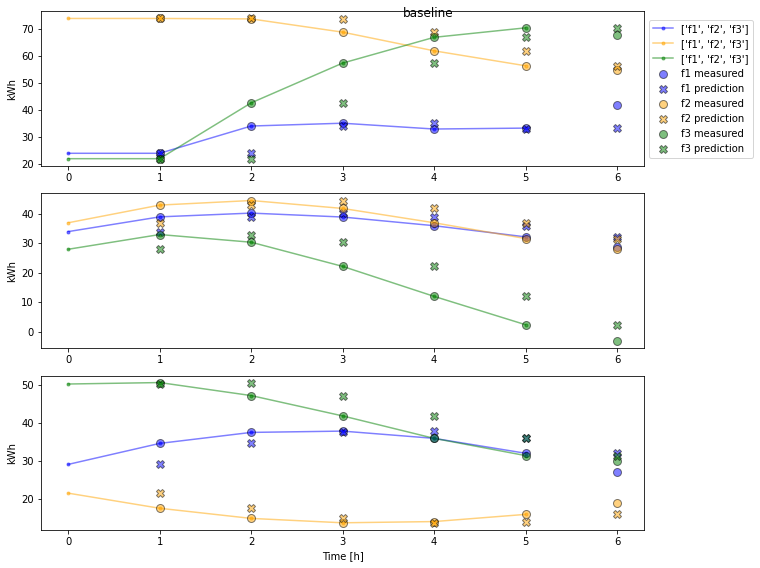

In [ ]:
val_performance = {}
test_performance = {}
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline = training_camp_21_22.models.baseline.Baseline(
        label_indices=[column_indices[f] for f in ["f1", "f2", "f3"]])

baseline_history = train_evaluate_model(
    baseline, monthly_window, quadrimestral_window, val_performance, test_performance)


Plot models

In [ ]:
def plot_models(model_list):

    for model in model_list:
        model_plot_path = os.path.join(
            training_camp_21_22.config.plot_path,
            f"{model.name}_model.png")
        os.makedirs(model_plot_path, exist_ok=True)
        model.summary()
        tf.keras.utils.plot_model(
            model, model_plot_path, show_shapes=True)


# Baseline model

In [ ]:
#app = test_features_ds_pd_2[test_features_ds_pd_2["date"] > "2022-05-01"]
app = features_df[['user_month_year', "billing_range.from_date", 'f1', 'f2', 'f3']]

In [ ]:
app[:12]

,user_month_year,billing_range.from_date,f1,f2,f3
0,90000_07_2022,2022-07-01,0.0,34.0,33.0
1,90000_08_2022,2022-08-01,0.0,25.0,35.0
2,90000_09_2022,2022-09-01,2.0,20.0,33.0
3,90000_10_2022,2022-10-01,4.0,12.0,40.0
4,90000_11_2022,2022-11-01,3.0,3.0,38.0
5,90000_12_2022,2022-12-01,2.0,4.0,39.0
6,90000_01_2023,2023-01-01,24.0,13.0,47.0
7,90000_02_2023,2023-02-01,34.0,14.0,54.0
8,90000_03_2023,2023-03-01,19.0,9.0,49.0
9,90000_04_2023,2023-04-01,9.0,17.0,39.0


In [ ]:
def baseline_predictions(df):
    df = df.drop(df[(df["billing_range.from_date"]=='2023-06-01')].index)
    return df

def create_kaggle_submission(df):

    def build_key(row):
        output = (
            str(row["user"]) + "_" +
            datetime.datetime.strftime(row["date"], "%m_%Y")) 
        return output

    #df["key"] = df.apply(build_key, axis=1)
    df.drop(["billing_range.from_date"], axis=1, inplace=True)
    df.rename(
        columns={
            "f1": "next_month_f1",
            "f2": "next_month_f2",
            "f3": "next_month_f3"},
            inplace=True)
    return df

In [ ]:
#baseline_predictions = baseline_predictions(app)
baseline_predictions = create_kaggle_submission(app)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
baseline_predictions

,user_month_year,next_month_f1,next_month_f2,next_month_f3
0,90000_07_2022,0.0,34.0,33.0
1,90000_08_2022,0.0,25.0,35.0
2,90000_09_2022,2.0,20.0,33.0
3,90000_10_2022,4.0,12.0,40.0
4,90000_11_2022,3.0,3.0,38.0
...,...,...,...,...
109995,99999_01_2023,46.0,49.0,20.0
109996,99999_02_2023,50.0,51.0,28.0
109997,99999_03_2023,49.0,46.0,37.0
109998,99999_04_2023,45.0,39.0,33.0


# Neural Models must be inserted here

In [ ]:
# Insert a list of models here
# (linear, echo-state network, dense, multi_step_dense, long-short time memory)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path, train = True):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    csv_df = pd.DataFrame(columns=[
      "user_month",
      "fasciaF1ConsumoFatturato",
      "fasciaF2ConsumoFatturato",
      "fasciaF3ConsumoFatturato",
      "res_address_code",
      "res_address_value",
      "dom_address_code",
      "dom_address_value",
      "next_f1",
      "next_f2",
      "next_f3"
    ])


    d = {}
    truth = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[1]) :
            # read consumer id
            user_month = row[0]

            # billing_range
            billing_range = bill['customData']['billing_range']
            energy = bill['customData']['energy']
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            

            d[i] = {
              'user_month' : user_month,
              'month': int(user_month.split('_')[1]),
              'f1' : float(energy['fasciaF1ConsumoFatturato']),
              'f2' : float(energy['fasciaF2ConsumoFatturato']),
              'f3' : float(energy['fasciaF3ConsumoFatturato']),
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value,
              'next_f1' : float(row[2]) if train == True else '',
              'next_f2' : float(row[3]) if train == True else '',
              'next_f3' : float(row[4]) if train == True else ''
            }
            i = i+1

          if(train):
            truth[j] = {'user_month' : user_month, 'next_f1' : row[2],
              'next_f2' : row[3],
              'next_f3' : row[4]}
            j += 1


    if(train):
      return pd.DataFrame.from_dict(d, "index"), pd.DataFrame.from_dict(truth, 'index')
    return  pd.DataFrame.from_dict(d, "index")


features_df, truth_df = convert_json_2_pd(json_input_path="data/task_2/train.csv")
test_df = convert_json_2_pd(json_input_path="data/task_2/test.csv", train = False)

770000it [01:35, 8040.61it/s]
110000it [00:13, 8293.36it/s]


In [ ]:
from sklearn.model_selection import train_test_split

X=features_df[['month', 'f1', 'f2', 'f3']]
#'res_address_code', 'res_address_value', 'dom_address_code','dom_address_value'

y=features_df[['next_f1', 'next_f2', 'next_f3']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
model = Sequential()

model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='linear'))
model.compile(loss='mae', optimizer='adam')

model.fit(X_train, y_train,epochs=6, verbose=1, validation_data=(X_val, y_val))

Epoch 1/6
16122/16122 [==============================] - 34s 2ms/step - loss: 8.2936 - val_loss: 7.2837
Epoch 2/6
16122/16122 [==============================] - 34s 2ms/step - loss: 7.3082 - val_loss: 7.2959
Epoch 3/6
16122/16122 [==============================] - 35s 2ms/step - loss: 7.3064 - val_loss: 7.2832
Epoch 4/6
16122/16122 [==============================] - 34s 2ms/step - loss: 7.3055 - val_loss: 7.2794
Epoch 5/6
16122/16122 [==============================] - 34s 2ms/step - loss: 7.3055 - val_loss: 7.2811
Epoch 6/6
16122/16122 [==============================] - 37s 2ms/step - loss: 7.3053 - val_loss: 7.2787


In [ ]:
X_test=test_df[['month', 'f1', 'f2', 'f3']]
preds = model.predict(X_test)

3438/3438 [==============================] - 13s 4ms/step


In [ ]:
baseline_predictions = pd.DataFrame(preds, columns = ['next_month_f1', 'next_month_f2', 'next_month_f3'])
baseline_predictions['user_month_year'] = ''
baseline_predictions['user_month_year'] = test_df['user_month']
baseline_predictions = baseline_predictions[['user_month_year', 'next_month_f1', 'next_month_f2', 'next_month_f3']]

In [ ]:
baseline_predictions

,user_month_year,next_month_f1,next_month_f2,next_month_f3
0,90000_07_2022,24.483849,832.385864,805.423523
1,90000_08_2022,21.953514,617.720093,853.701538
2,90000_09_2022,63.427010,501.145660,805.423035
3,90000_10_2022,100.955849,309.479187,968.615784
4,90000_11_2022,76.502342,99.786003,921.712769
...,...,...,...,...
109995,99999_01_2023,1124.768433,1214.449951,447.594360
109996,99999_02_2023,1213.479980,1261.064575,631.036133
109997,99999_03_2023,1179.908447,1138.521973,844.018433
109998,99999_04_2023,1085.924927,971.999512,755.605469


# Submit solution to Kaggle competition

Create a termporary folder for submissions

In [ ]:
!mkdir -p submissions

In [ ]:
baseline_predictions_path = "submissions/baseline.csv"
baseline_predictions.to_csv(baseline_predictions_path, index=False)

In [ ]:
!kaggle competitions submit -c pitc-2122-prediction -f "submissions/baseline.csv" -m "Dense NN prediction"

100% 4.50M/4.50M [00:00<00:00, 9.40MB/s]
Successfully submitted to PITC 21/22 - Prediction